# Consistent Bayes: Examples from the Paper
---

Copyright 2018 Michael Pilosov

Based on work done by ... 

### Import Libraries
_tested with python 3.6 on 02/11/18_

In [3]:
# Mathematics and Plotting
from HelperFuns import * # pyplot wrapper functions useful for visualizations, numpy, scipy, etc.
# %matplotlib inline
%matplotlib notebook
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 10, 5
from cbayes import sample, solve, distributions
# Interactivity
from ipywidgets import *

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Example Summary

---



---
## Define Functions

/Users/Imogen/anaconda3/envs/test_py_env/lib/python3.6/site-packages/matplotlib-2.1.2-py3.6-macosx-10.7-x86_64.egg/matplotlib/artist.py:896: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


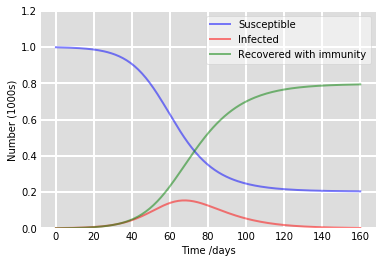

In [2]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def epidemic(beta=0.2, gamma = 0.1, N=1000, I0=1, R0=0, ):
    # I0 is number of initial infected individuals
    # R0 is number of initial  recovered individuals
    # S is everyone else, the susceptible 
    # beta is contact rate (socialness of society) (ppl/day)
    # gamma is recovery rate (days^-1)
    S0 = N - I0 - R0
    y0 = S0, I0, R0     # Initial conditions vector
    t = np.linspace(0, 160, 160) # time vector
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))


# Integrate the SIR equations over the time grid, t.

S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axis_bgcolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

--- 

# Sample from Prior


In [ ]:
PtO_fun_choice = 2
dist = 'beta' # for example 6.1. Ex 6.2 uses uniform.

input_dim = 2 # Specify input space dimension (n)
num_samples = int(1E4) # number of input samples (N)
s_set = sample.sample_set(size=(num_samples, input_dim))

if PtO_fun_choice == 1:
    PtO_fun = fun1
    if dist == 'beta':
        s_set.set_dist('beta', kwds={'a': 2, 'b': 5, 'loc': 0.79, 'scale': 0.20}, dim=0)
        s_set.set_dist('beta', kwds={'a': 2, 'b': 5, 'loc': 1-4.5*np.sqrt(0.1), 'scale': 9*np.sqrt(0.1)}, dim=1)
    elif dist == 'uni':
        s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 0.79, 'scale': 0.20}, dim=0)
        s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 1-4.5*np.sqrt(0.1), 'scale': 9*np.sqrt(0.1)}, dim=1)

elif PtO_fun_choice == 2:
    PtO_fun = fun2
    s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': -1, 'scale': 2}, dim=0)
    s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': -1, 'scale': 2}, dim=1)

s_set.generate_samples()

lam = s_set.samples # create a pointer for ease of reference later with plotting.

### Visualize Prior 

In [ ]:
widgets.interactive(pltdata, data = fixed(lam), inds = fixed(None), 
                    N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
                    eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
                    view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
                    view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))


---
# Compute Data Space $O(\Lambda) = \mathcal{D}$ 

Format: `(n_dims, n_samples)`  

In [ ]:
p_set = sample.map_samples_and_create_problem(s_set, PtO_fun)
D = p_set.output.samples

# this is how we handle trying to infer the dimension based on what the map put out.
try:
    output_dim = D.shape[1] # if your function was coded correctly, you should have an (n, d) data space.
except IndexError:
    print(Warning("Warning: Your map might be returning the wrong dimensional data."))
    try:
       output_dim = D.shape[0] 
    except IndexError:
        print(Warning("Warning: Guessing it's 1-dimensional."))
        output_dim = 1
print('dimensions :  lambda = '+str(lam.shape)+'   D = '+str(D.shape) )

# Compute Push-Forward of the Prior $P_{O(\Lambda)}$
_ ... i.e. Characterize the Data Space_

In [ ]:
# Interactive Marginal Visualization
p_set.compute_pushforward_dist()
pf_dist = p_set.pushforward_dist

In [ ]:
# pf_dist.kde_object.set_bandwidth(1E-10)

In [ ]:
widgets.interactive(pltdata, data = fixed(pf_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=10000, min = 100, max=10000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="brown", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


# Define Observed Probability Measure $P_\mathcal{D}$

In [ ]:
if PtO_fun_choice == 1:
    p_set.set_observed_dist('normal', {'loc':0.3, 'scale':0.025}) # default is normal based on the data space # for function choice = 1

elif PtO_fun_choice == 2:
    p_set.set_observed_dist('normal', {'loc':-2.0, 'scale':0.25**2}) # default is normal based on the data space # for function choice = 1


obs_dist = p_set.observed_dist # this is define a pointer for ease of reference.

widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


---

At this point we have performed the computations we need to. We have evaluated the input points through our map and performed a KDE on them. It would be useful at this point to save this object and/or its evaluation at every point in the data space for later re-use. Doing so here would be an appropriate place. 

--- 

# Accept/Reject Sampling of Posterior

Since we have already used the samples in our prior to compute the pushforward density, we can re-use these with an accept/reject algorithm to get a set of samples generated from the posterior according to the solution of the stochastic inverse problem as outlined in the Consistent Bayes formulation. 

In [ ]:
p_set.set_ratio()
eta_r = p_set.ratio
solve.problem(p_set)

In [ ]:
accept_inds = p_set.accept_inds
lam_accept = p_set.input.samples[accept_inds,:]
num_accept = len(accept_inds)
print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))

## Visualize Posterior Density
### (Visualize Accept/Reject Samples)


In [ ]:
widgets.interactive(pltdata, data = fixed(lam), inds = fixed(accept_inds), 
        N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept+1, step=1, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))

# You will visualize the accepted samples in a subset of size N of the input samples. 
# This is mostly for faster plotting, but also so you can see the progression of accepted sampling in the algorithm.


---
# Now what? 

Well, we can...

## _Visualize the Quality of our SIP Solution by Comparing it to the Observed_
_We compare the push-forward of the posterior using accepted samples against the observed density_  
_(SIP = Stochastic Inverse Problem)_
### Observed:

In [ ]:
widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))

## Pushforward of Posterior:

In [ ]:
widgets.interactive(pltdata, data = fixed(D), inds = fixed(accept_inds), 
        N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept-1, step=1, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="eggplant", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


## Verify our parametric test statistics.
Let's see if the pushforward of the posterior results in a sample mean and standard deviation that are close to the observed.

In [ ]:
[np.mean(D[accept_inds,:]), np.std(D[accept_inds,:])]

In [ ]:
[p_set.observed_dist.mean(), p_set.observed_dist.std()]

They look pretty good! Now go back to the [Sampling Section](#Sample-from-Prior) and change the distribution on the prior or choose another example problem.